In [1]:
from helper import *
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel

In [2]:
SUBSET = '20k'
DATA_DIR = 'data/'
DATA_FILENAME = '2d_subset' + SUBSET

In [3]:
(X_train, X2_train, y_train), (X_test, X2_test, y_test) = \
    load2x_npz(DATA_DIR + DATA_FILENAME + '.npz')

((20000, 9216, 2), dtype('uint8')) ((20000, 2304, 2), dtype('uint8')) ((20000,), dtype('uint8'))
((10000, 9216, 2), dtype('uint8')) ((10000, 2304, 2), dtype('uint8')) ((10000,), dtype('uint8'))


In [4]:
def compute_feats(img, kernels):
    feats = np.zeros((len(kernels), 2), dtype='float32')
    for i, kernel in enumerate(kernels):
        filtered = np.absolute(ndi.convolve(img, kernel, mode='constant'))
        feats[i, 0] = filtered.mean().astype('float32')
        feats[i, 1] = filtered.var().astype('float32')
    return feats

In [5]:
# Turn a <v> of size 11520 (96x96 + 48x48) into 1-D feature vector
# of size 4 (2 sizes x 2 features)
def vec_to_feat(v):
    feats1 = compute_feats(v[:9216].reshape(96, 96), kernels).ravel()
    feats2 = compute_feats(v[9216:].reshape(48, 48), kernels).ravel()
    return np.concatenate((feats1, feats2))

In [6]:
# prepare filter bank kernels
kernels = []
for theta in range(1):
    theta = theta / 2 * np.pi
    for sigma in (1.45,):
        for freq in (0.135,):
            kernels.append(gabor_kernel(freq, theta=theta, sigma_x=sigma, sigma_y=sigma).real)
len(kernels), kernels[0].shape

(1, (11, 11))

In [7]:
[k.shape for k in kernels]

[(11, 11)]

In [8]:
from math import ceil
def show(imgs):
    rows = ceil(len(imgs)/4)
    fig, ax = plt.subplots(rows, 4, figsize=(12,7))
    if rows == 1: ax = ax.reshape(1,-1)
    for i in range(rows * 4):
        col = i % 4
        row = i // 4
        ax[row][col].axis('off')
        if i >= len(imgs): 
            fig.delaxes(ax[row][col])
            continue
        ax[row][col].set_title(f'{i}')
        ax[row][col].imshow(np.absolute(imgs[i]), cmap='gray')
    fig.tight_layout()

In [9]:
scharr = np.array([[ -3-3j, 0-10j,  +3 -3j],
                   [-10+0j, 0+ 0j, +10 +0j],
                   [ -3+3j, 0+10j,  +3 +3j]])
kernels.append(scharr)

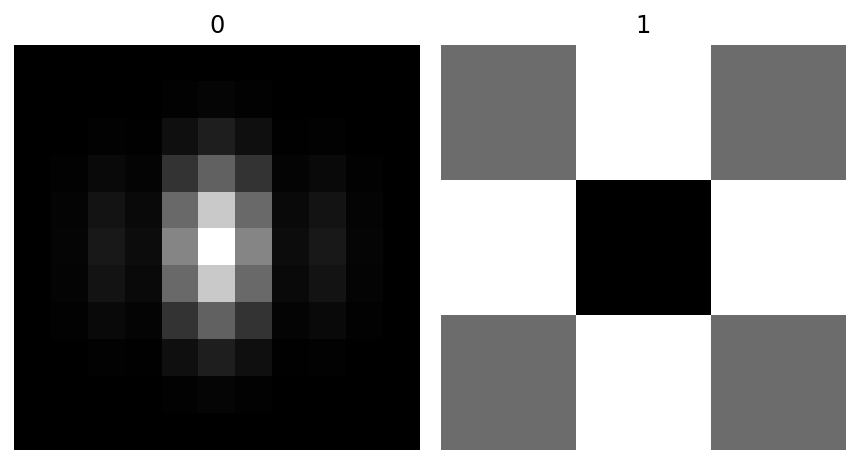

In [10]:
show(kernels)

In [11]:
def show_filt(v, kernels):
    img = v.reshape(96,96)
    imgs = [img]
    for kernel in kernels:
        imgs.append(np.absolute(ndi.convolve(img, kernel, mode='wrap')))
    show(imgs)

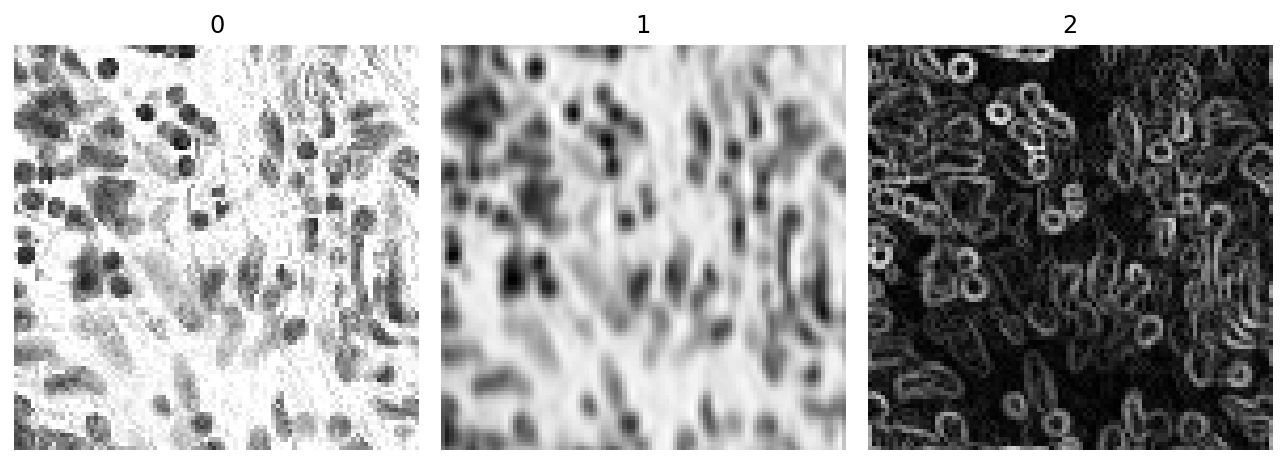

In [12]:
show_filt(X_train[1, :, 0], kernels)

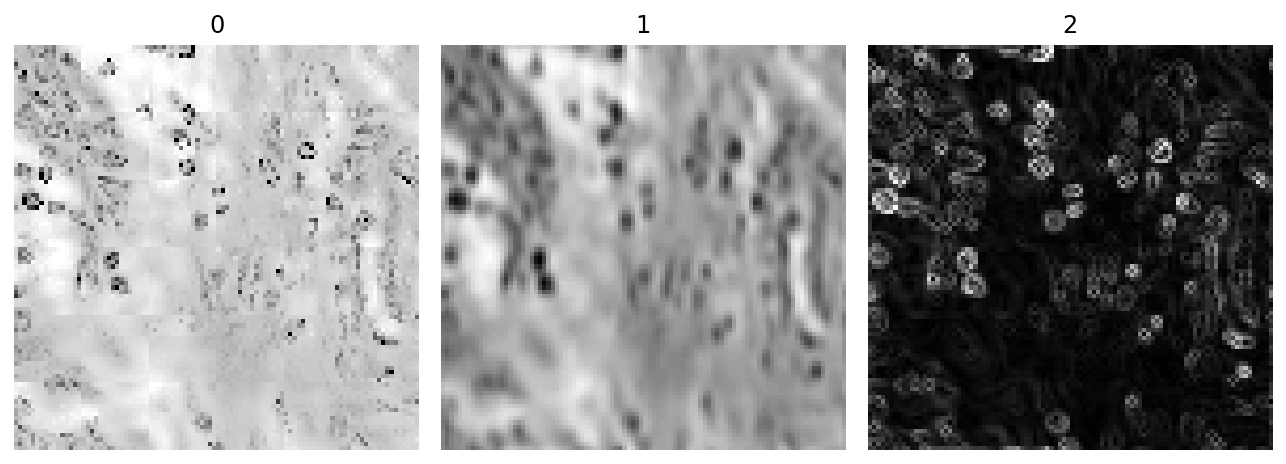

In [13]:
show_filt(X_train[1, :, 1], kernels)

In [14]:
Xf_train = np.apply_along_axis(delayed(vec_to_feat), 1, np.hstack((X_train, X2_train)))
Xf_train = [x for x in Xf_train[:, 0]], [x for x in Xf_train[:, 1]]
Xf_train = compute(Xf_train[0], Xf_train[1])
Xf_train = np.hstack((np.array(Xf_train[0]), np.array(Xf_train[1])))
Xf_train.shape, Xf_train.dtype

((20000, 16), dtype('float32'))

In [15]:
Xf_test = np.apply_along_axis(delayed(vec_to_feat), 1, np.hstack((X_test, X2_test)))
Xf_test = [x for x in Xf_test[:, 0]], [x for x in Xf_test[:, 1]]
Xf_test = compute(Xf_test[0], Xf_test[1])
Xf_test = np.hstack((np.array(Xf_test[0]), np.array(Xf_test[1])))
Xf_test.shape, Xf_test.dtype

((10000, 16), dtype('float32'))

In [16]:
SUBSET_FILENAME = '2d_gaboscharr_subset' + SUBSET
np.savez(DATA_DIR + SUBSET_FILENAME,
         X_train=Xf_train, y_train=y_train,
         X_test=Xf_test, y_test=y_test)

In [17]:
GBT(Xf_train, Xf_test, y_train, y_test)

n_est: Train, Test
400  : 87.4,  84.9
600  : 89.0,  85.1
800  : 90.2,  85.2
